# 2.A. What to do with a `DynamicalSystem`? Orbit Diagram
An "orbit diagram" is simply a plot that shows the long term behavior of a discrete system when a parameter is varied. 

How does one compute it?
1. Evolves the system for a transient amount of time.
2. Evolves & saves the output of the system for a chosen amount of time.
3. Changes/increments a parameter of the equations of motion.
4. Repeat steps 1-3 for all given parameter values.

This is exactly what the function `orbitdiagram` does!


---

Let's make the super-ultra-famous orbit diagram of the logistic map:

$$x_{n+1} = rx_n(1-x_n)$$

In [1]:
using DynamicalSystems
using PyPlot
PyPlot.rc("font", size = 16)          # set default fontsize
PyPlot.rc("figure", figsize = (6, 4)) # set default figsize

logimap = Systems.logistic() # Systems module contains pre-defined well-known systems

1-dimensional discrete dynamical system
 state:       0.20362911678078932
 e.o.m.:      logistic_eom
 in-place?    false
 jacobian:    logistic_jacob
 parameters:  [4.0]

---

The call signature of `orbitdiagram` is:

```julia
orbitdiagram(discrete_system, i, p_index, pvalues; n, Ttr, ...)
```
* `i` is the index of the variable we want to save (for which variable to create the orbit diagram).
* `p_index` is the index of the parameter we want to change.
* `pvalues` are the values of the parameter that will change.
* Keywords `Ttr` and `n` denote for how much transient time to evolve the system and how many steps to save.


In [2]:
i = 1
n = 2000 # how many values to save
Ttr = 2000 # transient iterations
p_index = 1
pvalues = 2:0.001:4  # parameter values
output = orbitdiagram(logimap, i, p_index, pvalues; n = n, Ttr = Ttr)
typeof(output)

Array{Array{Float64,1},1}

* The output is a vector of vectors. Each inner vector has length `n` and contains the values of the `i`-th variable at the given parameter value.

---

Let's plot this!

In [3]:
function plot_od(r1, r2, n = 1000, Ttr = 1000)

    params = range(r1, stop = r2, length = 1001)

    res = orbitdiagram(logimap, 1, 1, params; n = n, Ttr = Ttr)
    title = "computed points: $(Float64(length(res)*(n+Ttr))), plotted: $(Float64(length(res)*n))"
    L = length(params)

    # Convert all orbit diagram to single vectors (faster to plot)
    x = Vector{Float64}(undef, n*L)
    y = copy(x)
    for j in 1:L
        x[(1 + (j-1)*n):j*n] .= params[j]
        y[(1 + (j-1)*n):j*n] .= res[j]
    end

    plot(x, y, ls = "None", ms = 0.2, color = "black", marker = "o", alpha = 0.05)
    xlim(r1, r2)
    xlabel("\$r\$"); ylabel("\$x\$")
    tight_layout()

end

plot_od (generic function with 3 methods)

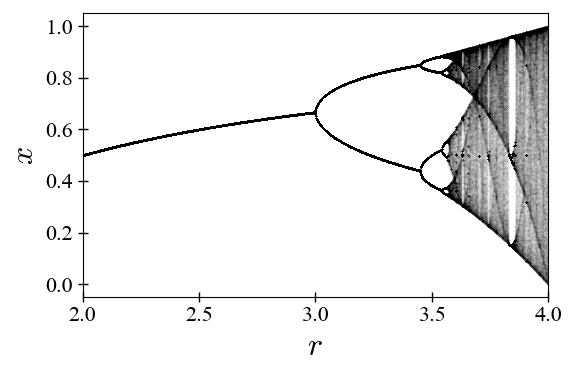

In [4]:
plot_od(2, 4.0)

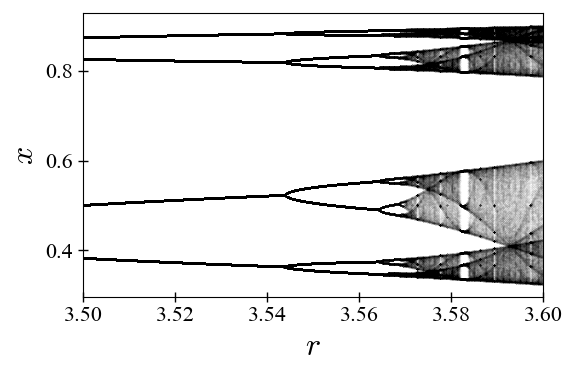

In [5]:
plot_od(3.5, 3.6)

---

* `orbitdiagram` works with *any* discrete system! Check out the [documentation page](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/orbitdiagram/) for more!

# 2.B. Poincaré Surface of Section
This is a technique to reduce a continuous system into a discrete map with 1 fewer dimension.
The wikipedia entry on [Poincaré map](https://en.wikipedia.org/wiki/Poincar%C3%A9_map) has a lot of useful info, but the technique itself is very simple:

1. Define a hyperplane in the phase-space of the system. 
2. Evolve the continuous system for long times. Each time the trajectory crosses this plane, record the state of the system.
3. Only crossings with a specific direction (either positive or negative) are allowed.

And that's it! The recorded crossings are the Poincaré Surface of Section!

## Defining a hyperplane
Let's say that our phase-space is $D$ dimensional. If the state of the system is $\mathbf{u} = (u_1, \ldots, u_D)$ then the equation for a hyperplane is 

$$
a_1u_1 + \dots + a_Du_D = \mathbf{a}\cdot\mathbf{u}=b 
$$
where $\mathbf{a}, b$ are the parameters that define the hyperplane.

---

Here is the call signature for a function that does this:

```julia
poincaresos(continuous_system, plane, tfinal = 100.0; kwargs...)
```
In code, `plane` can be either:

* A `Tuple{Int, <: Number}`, like `(j, r)` : the hyperplane is defined as when the `j`-th variable of the system crosses the value `r`.
* An `AbstractVector` of length `D+1`. The first `D` elements of the vector correspond to $\mathbf{a}$ while the last element is $b$. The hyperplane is defined with its formal equation.

---

As an example, let's see a section of the Lorenz system:
$$
\begin{aligned}
\dot{X} &= \sigma(Y-X) \\
\dot{Y} &= -XZ + \rho X -Y \\
\dot{Z} &= XY - \beta Z
\end{aligned}
$$


In [6]:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

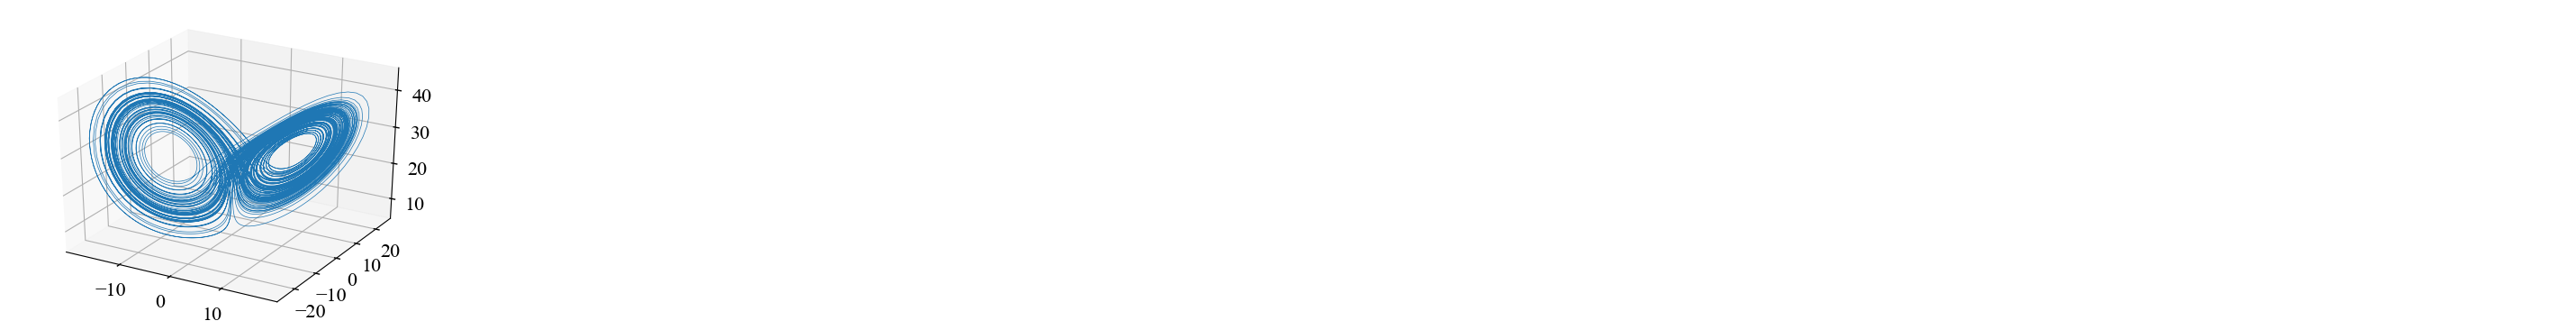

In [7]:
tr = trajectory(lor, 100.0, dt = 0.01, Ttr = 50.0)
figure(figsize = (6,4))
x, y, z = columns(tr)
plot3D(x,y,z, lw = 0.5);

**First, let's visualize the Poincaré Surface of Section in 3D**

In [8]:
c = Vector{String}(undef, length(y))
for i in 1:length(y) # cut points: red
    if -0.1 < y[i] < 0.1
        c[i] = "C3"
    elseif y[i] < 0 
        c[i] = "C0" # in front of cut: blue
    else
        c[i] = "C2" # behind cut: green
    end
end

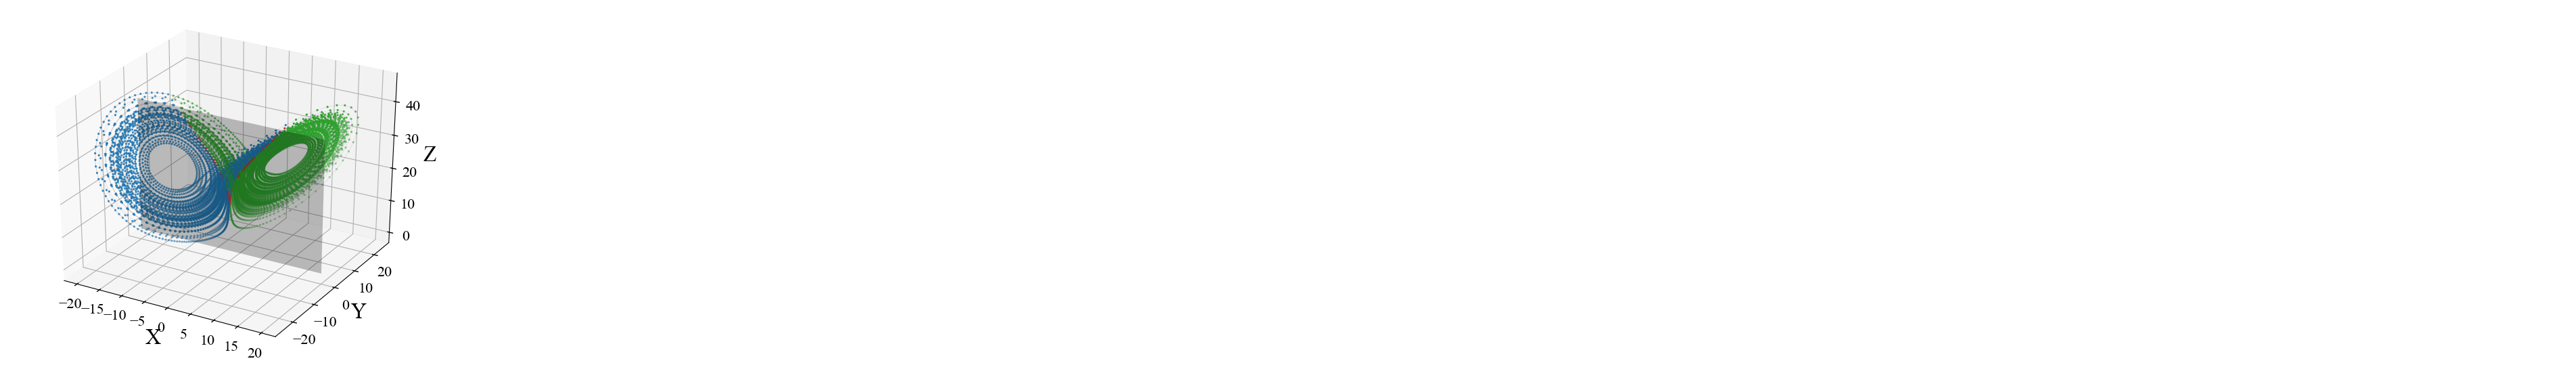

In [9]:
figure(figsize = (8,6))

# First let's plot the attractor
plot3D(x,y,z, color = "black", lw = 0.2, alpha = 0.25)
scatter3D(x, y, z, color = c, s = 3.0)

# And then plot the PSOS plane:
function meshgrid(vx, vy)
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n); vy = reshape(vy, m, 1)
    (repeat(vx, m, 1), repeat(vy, 1, n))
end
xx = [-20, 20]; zz = [0, 40]; 
X, Z = meshgrid(xx, zz)
Y = zero(X)

plot_surface(X, Y, Z, alpha = 0.25, color = "k");
xlabel("X"); ylabel("Y"); zlabel("Z");

**Now let's use the `poincaresos` function**

In [10]:
plane = (2, 0.0) # when 2nd variable crosses 0.0

(2, 0.0)

In [11]:
psos_chaotic = poincaresos(lor, plane, 2000.0, Ttr = 100.0)

3-dimensional Dataset{Float64} with 965 points
   3.02739    4.15624e-5   25.8971
  -8.34307   -8.534e-6     35.1256
  -4.32582   -1.41457e-10  28.3285
  -8.93501   -2.74811e-7   36.1135
  -8.93831   -8.34545e-6   36.1193
  -8.95441   -4.74464e-6   36.1462
  -9.03023   -8.66017e-7   36.2731
  -9.38776   -8.41964e-6   36.8724
 -11.3523    -2.65693e-7   40.2088
   0.615282  -3.57687e-10  19.1521
  -8.37817   -8.48338e-6   35.1837
  -5.29963   -0.000158383  30.0264
  -9.24986   -5.31516e-6   36.6408
   ⋮                              
  -8.37183   -1.40695e-6   35.1735
  -5.20055   -0.000758366  29.8559
  -9.1942    -4.02204e-6   36.5475
 -10.1922    -7.01275e-6   38.2288
   3.31562    0.00076992   26.4614
  -8.61874   -6.84637e-6   35.5853
  -7.32945   -2.05146e-6   33.4382
 -12.2932    -6.07414e-10  41.84  
   0.790674   1.85841e-11  19.9681
  -7.0028    -6.42751e-7   32.8936
 -11.269     -3.27532e-7   40.0657
 -12.3163     2.53148e-7   41.8803


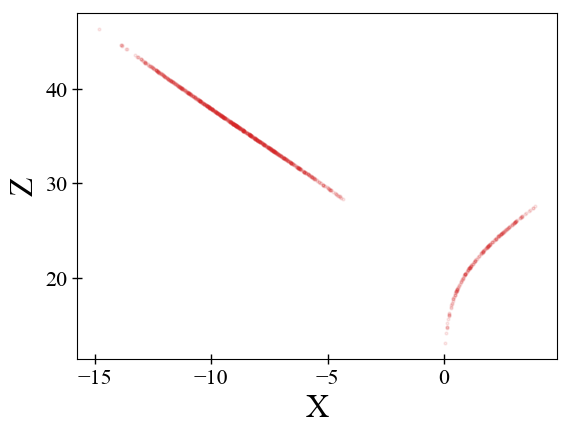

In [12]:
figure(figsize = (6,4))
plot(psos_chaotic[:, 1], psos_chaotic[:, 3], lw=0.0, marker ="o", ms = 2.0, alpha = 0.1, color = "C3");
xlabel("X"); ylabel("Z");

* We see that the surface of section is some kind of 1-dimensional object. 
* This is expected, because as we will show in the tutorial "Entropies & Dimensions" the Lorenz system (at least for the default parameters) lives in an almost 2-dimensional attractor.

* This means that when you take a cut through this object, the result should be 1-dimensional!

Let's now compute the PSOS for a parameter value where the Lorenz system is stable instead of chaotic:

In [13]:
set_parameter!(lor, 2, 69.75)

psos_regular = poincaresos(lor, (2, 0.0), 2000.0, Ttr = 100.0)
summary(psos_regular)

"3-dimensional Dataset{Float64} with 1710 points"

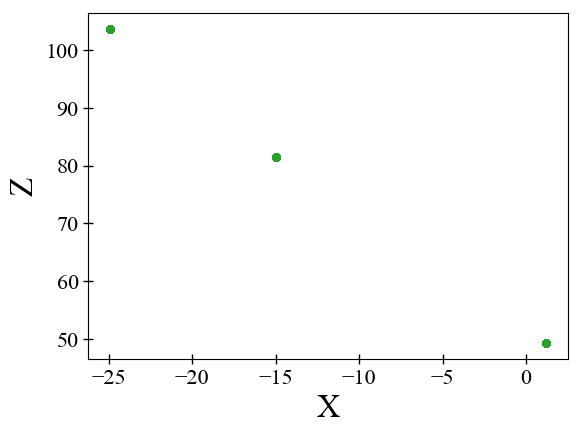

In [14]:
figure(figsize = (6,4))
plot(psos_regular[:, 1], psos_regular[:, 3], lw=0.0, marker ="o", ms = 5.0, alpha = 0.1, color = "C2");
xlabel("X"); ylabel("Z");

And here are the two different PSOS plots side by side:

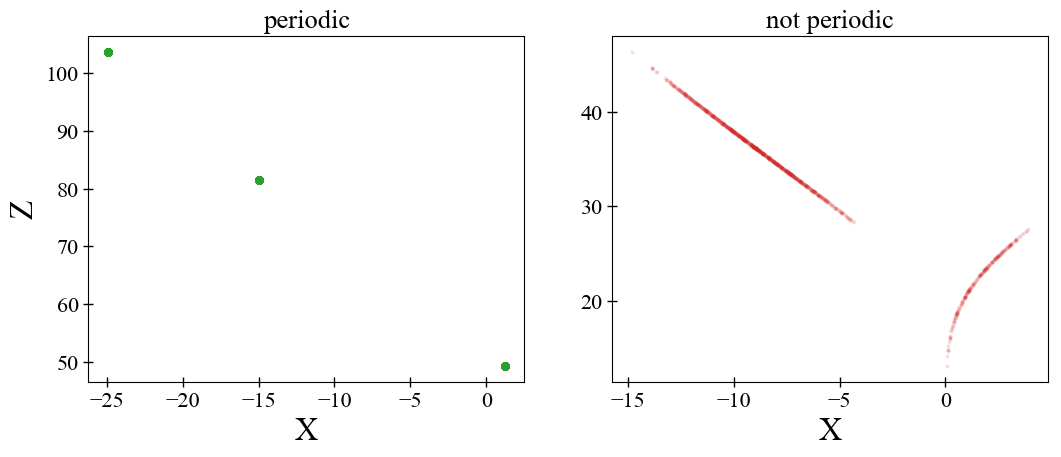

In [15]:
figure(figsize = (12,4))
subplot(121)
plot(psos_regular[:, 1], psos_regular[:, 3], lw=0.0, marker ="o", ms = 5.0, color = "C2", alpha = 0.1);
xlabel("X"); ylabel("Z"); title("periodic")
subplot(122)
plot(psos_chaotic[:, 1], psos_chaotic[:, 3], lw=0.0, marker ="o", ms = 2.0, color = "C3", alpha = 0.1);
xlabel("X"); title("not periodic");

# 2.C. Lyapunov exponents

## Definition
Lyapunov exponents measure the exponential separation rate of trajectories that are (initially) close. 

Consider the following picture, where two nearby trajectories are evolved in time:
 

<img src="lyapunov.png" alt="Sketch of the Lyapunov exponent" style="width: 500px;"/>


* $\lambda$ denotes the "maximum Lyapunov exponent".
* A $D$-dimensional system has $D$ exponents.
* In general, a trajectory is called "chaotic" if
    1. it follows nonlinear dynamics
    2. it is *bounded* (does not escape to infinity)
    2. it has at least one positive Lyapunov exponent

*(please be aware that the above is an over-simplification! See the textbooks cited in our documentation for more)*

---

## Demonstration

Before computing Lyapunov exponents, we'll demonstrate the concept of exponential separation using the Henon map that we used before

$$
\begin{aligned}
x_{n+1} &= 1 - ax_n^2 + y_n \\
y_{n+1} &= bx_n
\end{aligned}
$$

In [16]:
henon = Systems.henon()

2-dimensional discrete dynamical system
 state:       [0.0, 0.0]
 e.o.m.:      hoop
 in-place?    false
 jacobian:    hoop_jac
 parameters:  [1.4, 0.3]

First we'll generate a trajectory for the towel map, `tr1`, from the default initial condition,

In [17]:
tr1 = trajectory(henon, 100)
summary(tr1)

"2-dimensional Dataset{Float64} with 101 points"

and then we will generate a second trajectory, `tr2`, with a starting point slightly shifted from the initial condition of `tr1`.

In [18]:
u2 = get_state(henon) + (1e-9 * ones(dimension(henon)))
tr2 = trajectory(henon, 100, u2)
summary(tr2)

"2-dimensional Dataset{Float64} with 101 points"

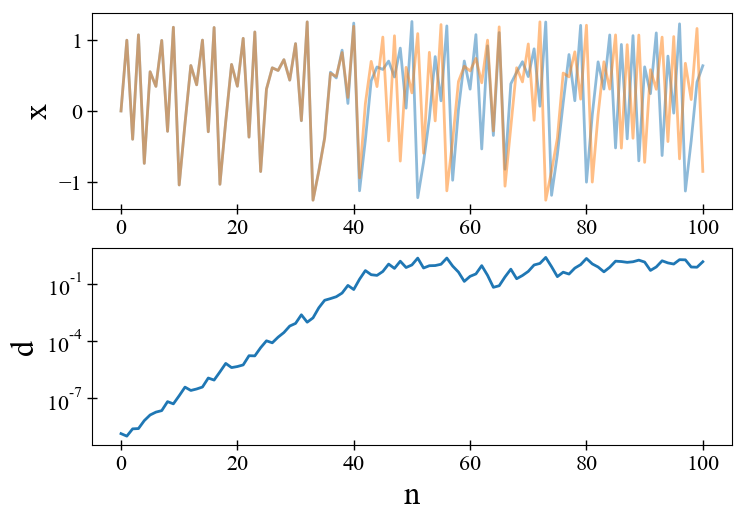

In [19]:
using LinearAlgebra: norm

figure(figsize=(8,5))

# Plot the x-coordinate of the two trajectories:
ax1 = subplot(2,1,1)
plot(tr1[:, 1], alpha = 0.5)
plot(tr2[:, 1], alpha = 0.5)
ylabel("x")

# Plot their distance in a semilog plot:
ax2 = subplot(2,1,2, sharex = ax1)
d = [norm(tr1[i] - tr2[i]) for i in 1:length(tr2)]
ylabel("d"); xlabel("n"); semilogy(d);

### Computing the Lyapunov Exponents

`lyapunov` is a function that calculates the maximum Lyapunov exponent for a DynamicalSystem (for a given starting point).

In [20]:
λ = lyapunov(henon, 5000) # second argument is time to evolve

0.424089183372981

This number is _approximately_ the slope of the distance increase!



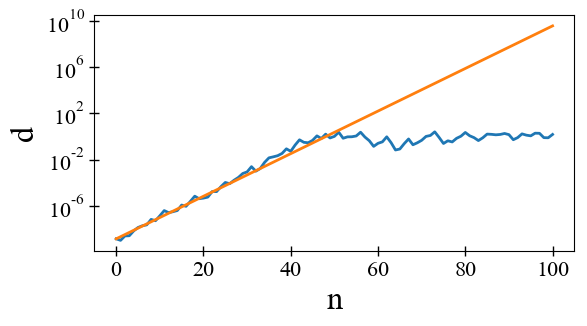

In [21]:
figure(figsize=(6,6))
# Plot the increasing distance of trajectories
ax2 = subplot(2,1,2, sharex = ax1)
d = [norm(tr1[i] - tr2[i]) for i in 1:length(tr2)]
x = 0:length(d)-1
semilogy(x, d);

# plot a line with exponential slope given by λ
plot(x, d[1] .* exp.(x .* λ))
ylabel("d"); xlabel("n");

If you want to get more than one Lyapunov exponents of a system, use `lyapunovs`

## Continuous systems

* All functions that accept a `DynamicalSystem` work with *any* instance of `DynamicalSystem`, regardless of whether it is continuous, discrete, in-place, out-of-place, with Jacobian or whatever.
* `lyapunov` and `lyapunovs` both accept a `DynamicalSystem`.

This means that they will "just work" if we use the Lorenz system, `lor`.


In [22]:
lor = Systems.lorenz()
lyapunov(lor, 2000.0)

0.8958642516537112

In [23]:
lyapunovs(lor, 2000)

3-element Array{Float64,1}:
   0.8999461456026728   
  -0.0003503451250100306
 -14.566262399180976    

Remember from the Poincare section that for some parameter values the Lorenz system was periodic, for others it was not.

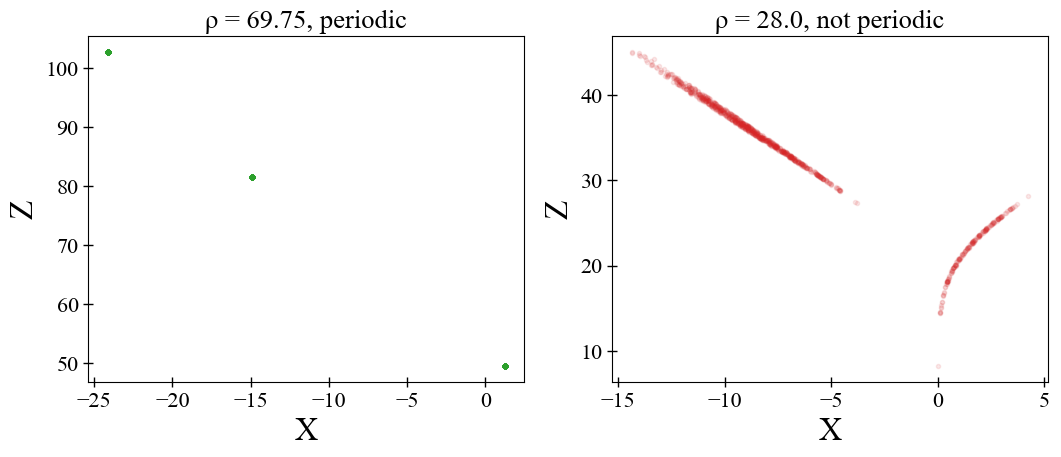

In [24]:
figure(figsize = (12,4))

ρs = (69.75, 28.0)

for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    psos = poincaresos(lor, (2, 0.0), 2000.0, Ttr = 20000.0) # find where 2nd variable crosses 0.0
    subplot(1,2,i)
    plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 3.0, color = "C$(i+1)", alpha = 0.1);
    xlabel("X"); ylabel("Z"); title("ρ = $ρ, " * (i != 1 ? "not periodic" : "periodic"))
end

Seems like the exponent in the first case λ should be equal to zero, and in the second λ should be positive.

In [25]:
for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    λ = lyapunov(lor, 2000.0; Ttr = 2000.0)
    println("For ρ = $ρ, λ = $λ")
end

For ρ = 69.75, λ = 0.000576217375328582
For ρ = 28.0, λ = 0.9076793841370797


One has to be **very careful** when using functions like `lyapunovs`. They are approximative methods! Naively doing short computations or not using large transient times can lead to wrong results!

In [26]:
for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    λ = lyapunov(lor, 200.0) # notice the much smaller integration times
    println("For ρ = $ρ, λ = $λ")
end

For ρ = 69.75, λ = 0.18228308312458585
For ρ = 28.0, λ = 0.7879613263962492


## Benchmarks

The Lyapunov exponent computations are quite fast! To benchmark them we can use the `BenchmarkTools` package. In addition, we will use a specific algorithm from DifferentialEquations.jl (for consistency).

In [27]:
using BenchmarkTools, OrdinaryDiffEq

In [28]:
diffeq = (alg = Vern9(), rtol = 1e-9, atol = 1e-9) # 9th order solver and very high accuracies

(alg = Vern9(true), rtol = 1.0e-9, atol = 1.0e-9)

In [29]:
@btime lyapunovs($lor, 2000; Ttr = 200, $diffeq...);

  79.742 ms (162802 allocations: 9.95 MiB)


In [30]:
@btime lyapunov($lor, 2000; Ttr = 200, $diffeq...);

  78.693 ms (701 allocations: 54.31 KiB)


Discrete systems are even faster!

In [31]:
tow = Systems.towel() # 3D discrete chaotic system

3-dimensional discrete dynamical system
 state:       [0.085, -0.121, 0.075]
 e.o.m.:      eom_towel
 in-place?    false
 jacobian:    jacob_towel
 parameters:  nothing

In [32]:
@btime lyapunovs($tow, 2000; Ttr = 200);

  250.880 μs (44 allocations: 3.95 KiB)


In [33]:
@btime lyapunov($tow, 2000; Ttr = 200);

  53.760 μs (17 allocations: 1.59 KiB)


# 2.D. How **DynamicalSystems.jl** is a library

What if the command `lyapunov(ds, 2000)` is too magical for you? Given that you have a basic idea of what a Lyapunov exponent is, you still don't know _how_ the function `lyapunov` actually computes it.

And knowing _exactly_ how a function computes stuff is really important for science!

For this, we turn to its documentation string:

In [34]:
?lyapunov

search: lyapunov lyapunovs numericallyapunov



```
lyapunov(ds::DynamicalSystem, Τ; kwargs...) -> λ
```

Calculate the maximum Lyapunov exponent `λ` using a method due to Benettin [1], which simply evolves two neighboring trajectories (one called "given" and one called "test") while constantly rescaling the test one. `T`  denotes the total time of evolution (should be `Int` for discrete systems).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the trajectories before starting to measure the expontent. Should be `Int` for discrete systems.
  * `d0 = 1e-9` : Initial & rescaling distance between the two neighboring trajectories.
  * `upper_threshold = 1e-6` : Upper distance threshold for rescaling.
  * `lower_threshold = 1e-12` : Lower distance threshold for rescaling (in order to  be able to detect negative exponents).
  * `dt = 1` : Time of evolution between each check of distance exceeding the thresholds. For continuous systems this is approximate.
  * `inittest = (u1, d0) -> u1 .+ d0/sqrt(D)` : A function that given `(u1, d0)` initializes the test state with distance `d0` from the given state `u1` (`D` is the dimension of the system). This function can be used when you want to avoid the test state appearing in a region of the phase-space where it would have e.g. different energy or escape to infinity.
  * `diffeq...` : Keyword arguments propagated into `init` of DifferentialEquations.jl. See [`trajectory`](@ref) for examples. Only valid for continuous systems.

## Description

Two neighboring trajectories with initial distance `d0` are evolved in time. At time $t_i$ their distance $d(t_i)$ either exceeds the `upper_threshold`, or is lower than `lower_threshold`, which initializes a rescaling of the test trajectory back to having distance `d0` from the given one, while the rescaling keeps the difference vector along the maximal expansion/contraction direction: $u_2 \to u_1+(u_2−u_1)/(d(t_i)/d_0)$.

The maximum Lyapunov exponent is the average of the time-local Lyapunov exponents

$$
\lambda = \frac{1}{t_{n} - t_0}\sum_{i=1}^{n}
\ln\left( a_i \right),\quad a_i = \frac{d(t_{i})}{d_0}.
$$

## Performance Notes

This function uses a [`parallel_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the low level method that accepts an integrator, and `reinit!` it to new initial conditions. See the "advanced documentation" for info on the integrator object. The low level method is

```
lyapunov(pinteg, T, Ttr, dt, d0, ut, lt)
```

## References

[1] : G. Benettin *et al.*, Phys. Rev. A **14**, pp 2338 (1976)


---

**All** documentation strings of functions exported by **DynamicalSystems.jl** have this structure:

1. Call signature
2. Couple of sentences explanation of what the function does
2. Keyword argument listing
3. Scientific description of the algorithm used
4. References

This way not only you get the basic idea of how the function works, but if this is not enough for you and want to learn more, you can look at the references!

# 2.E. More library: the GALI algorithm

For this part we will simply visit the documentation page of **DynamicalSystems.jl** and use the search function.

https://juliadynamics.github.io/DynamicalSystems.jl/latest/